In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

IMAGE_SIZE = 128
MASK_SIZE = 128

# Dataset Familarization

In [16]:
import pandas as pd
root_dir = "/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m"
csv_path = "/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/data.csv"
df = pd.read_csv(csv_path)
print(df.head())

        Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0  

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [17]:
df.describe()

,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
count,92.000000,109.000000,110.000000,108.000000,98.000000,105.000000,110.000000,109.000000,109.000000,109.0,109.000000,109.000000,109.000000,109.000000,108.000000,102.000000,109.000000
mean,2.445652,3.678899,1.900000,1.722222,2.367347,1.895238,1.763636,2.128440,1.532110,1.0,2.009174,3.513761,1.486239,45.834862,2.907407,1.970588,0.247706
std,1.180092,1.169684,0.789263,0.862872,1.125045,0.663960,0.855927,0.850935,0.501273,0.0,0.995317,1.863960,0.502119,13.797151,0.291212,0.169792,0.433674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,20.000000,2.000000,1.000000,0.000000
25%,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,2.000000,1.000000,34.000000,3.000000,2.000000,0.000000
50%,2.000000,4.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.0,2.000000,2.000000,1.000000,47.000000,3.000000,2.000000,0.000000
75%,4.000000,5.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.0,3.000000,6.000000,2.000000,58.000000,3.000000,2.000000,0.000000
max,4.000000,5.000000,4.000000,3.000000,4.000000,3.000000,3.000000,3.000000,2.000000,1.0,3.000000,6.000000,2.000000,75.000000,3.000000,2.000000,1.000000


In [18]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Patient                       0
RNASeqCluster                18
MethylationCluster            1
miRNACluster                  0
CNCluster                     2
RPPACluster                  12
OncosignCluster               5
COCCluster                    0
histological_type             1
neoplasm_histologic_grade     1
tumor_tissue_site             1
laterality                    1
tumor_location                1
gender                        1
age_at_initial_pathologic     1
race                          2
ethnicity                     8
death01                       1
dtype: int64


## Image Shapes and modes:

In [19]:
import os
from glob import glob
from PIL import Image

# Define dataset path
image_files = glob(os.path.join(root_dir, "**/*.tif"), recursive=True)
shapes = [(Image.open(img).size, Image.open(img).mode) for img in image_files]
print("(Image shape, Image mode): ", set(shapes))  
print("Number of Images: ", len(image_files))

(Image shape, Image mode):  {((256, 256), 'L'), ((256, 256), 'RGB')}
Number of Images:  7858


## Checking for missing masks and images

In [20]:
# Collect all images and masks
image_files = sorted(glob(os.path.join(root_dir, "**/*.tif"), recursive=True))
mask_files = sorted(glob(os.path.join(root_dir, "**/*_mask.tif"), recursive=True))

# Extract base names (without paths)
image_names = {os.path.basename(f).replace(".tif", "") for f in image_files if "_mask" not in f}
mask_names = {os.path.basename(f).replace("_mask.tif", "") for f in mask_files}
image_mask_pairs = [(img, img.replace(".tif", "_mask.tif")) for img in image_files if os.path.basename(img).replace(".tif", "") in mask_names]

missing_masks = image_names - mask_names 
missing_images = mask_names - image_names


print(f"Total Images: {len(image_names)}, Total Masks: {len(mask_names)}")
print(f"Missing Masks: {len(missing_masks)}")
print(f"Missing Images: {len(missing_images)}")

if missing_masks:
    print("Images without masks:")
    print(missing_masks)

if missing_images:
    print("Masks without corresponding images:")
    print(missing_images)


Total Images: 3929, Total Masks: 3929
Missing Masks: 0
Missing Images: 0


In [21]:
import matplotlib.pyplot as plt
from PIL import Image
def plot_images(n, image_mask_pairs):
    plt.figure(figsize=(15, 10))

    for i, (image_path, mask_path) in enumerate(image_mask_pairs[0:n]):
       
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        plt.subplot(10, 2, 2*i + 1)
        plt.imshow(image, cmap=None)
        plt.title(f"Image {i+1}")
        plt.axis('off')
        
        plt.subplot(10, 2, 2*i + 2)
        plt.imshow(mask, cmap=None)
        plt.title(f"Mask {i+1}")
        plt.axis('off')
    plt.subplots_adjust(hspace=0.3, wspace=0.05)
    plt.tight_layout()
    plt.show()

## Display of 10 images and their corresponding masks

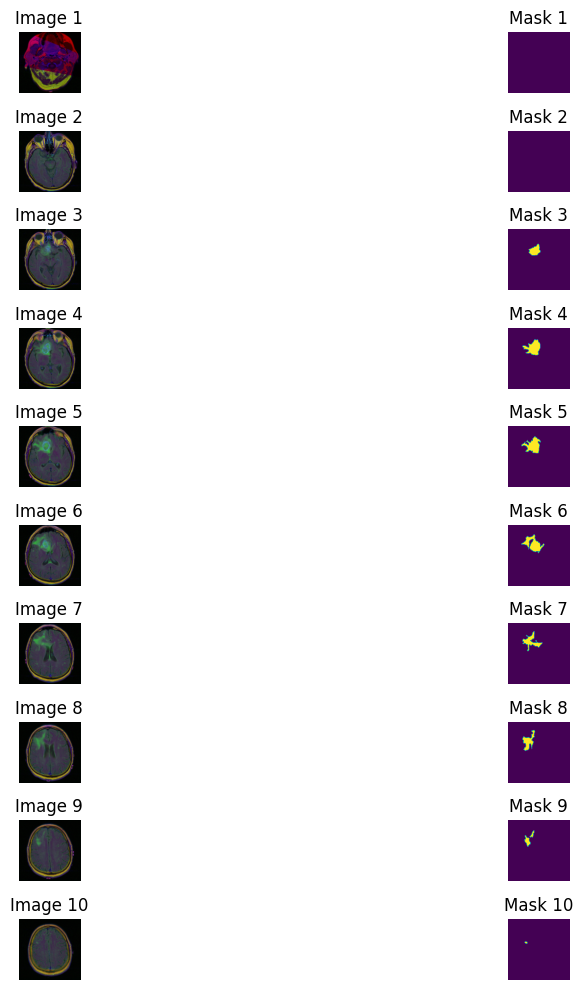

In [22]:
plot_images(10, image_mask_pairs)

# Preprocessing

## Normalizing and Resizing

In [23]:
import cv2
from glob import glob
from sklearn.model_selection import train_test_split

output_dir = "/kaggle/working/preprocessed_data"
image_mask_pairs = []
os.makedirs(output_dir, exist_ok=True)

# Set target size
IMAGE_DIMS = (IMAGE_SIZE, IMAGE_SIZE)
MASK_DIMS = (MASK_SIZE, MASK_SIZE)

patient_folders = sorted(os.listdir(root_dir))

images, masks = [], []
for patient in patient_folders:
    case_path = os.path.join(root_dir, patient)
    
    if not os.path.isdir(case_path):
        continue

    image_files = sorted(glob(os.path.join(case_path, "*.tif")))

    for image_file in image_files:
        image_name = os.path.basename(image_file)

        if "_mask" in image_name:
            continue

        image = Image.open(image_file)
        image_array = np.array(image, dtype=np.float32)

        # Apply Min-Max Normalization
        image_normalized = (image_array - image_array.min()) / (image_array.max() - image_array.min() + 1e-8)

        # Resize to target shape
        image_resized = cv2.resize(image_normalized, IMAGE_DIMS, interpolation=cv2.INTER_LINEAR)

        # Process corresponding mask
        mask_name = image_name.replace(".tif", "_mask.tif")
        mask_path = os.path.join(case_path, mask_name)

        if os.path.exists(mask_path):
            mask = Image.open(mask_path)
            mask_array = np.array(mask, dtype=np.float32)

            # Ensure binary mask (0,1)
            mask_array = (mask_array > 0).astype(np.float32)

            # Resize mask
            mask_resized = cv2.resize(mask_array, MASK_DIMS, interpolation=cv2.INTER_NEAREST)

            
            images.append(image_resized)
            masks.append(mask_resized)
            image_mask_pairs.append((image_resized, mask_resized))
images = np.array(images).reshape(-1, IMAGE_DIMS[0], IMAGE_DIMS[1], 3)  
masks = np.array(masks).reshape(-1, MASK_DIMS[0], MASK_DIMS[1], 1) 


## 10 images with their corresponding masks after normalization and resizing

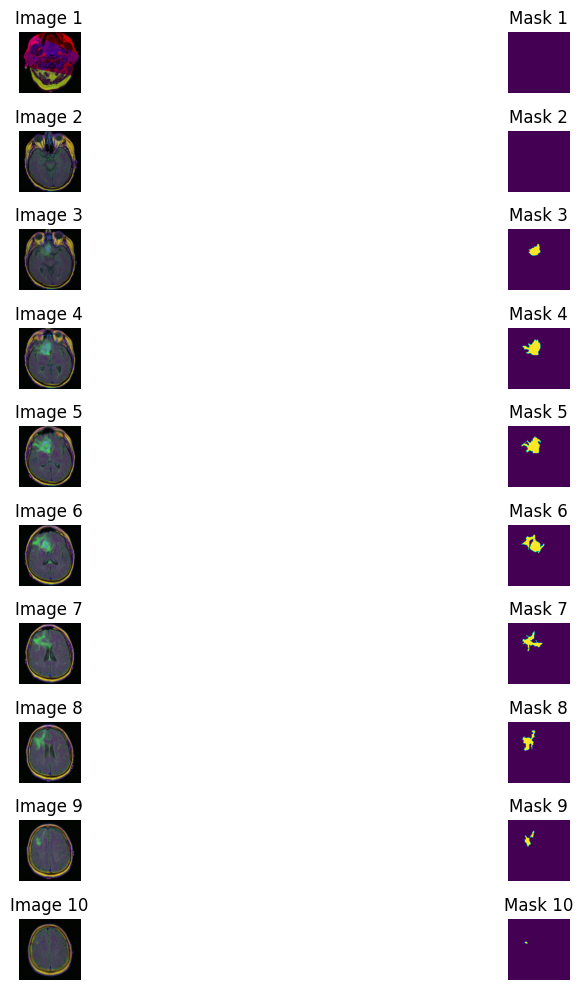

image_size:  {49152}
mask_size:  {16384}


In [24]:
plt.figure(figsize=(15, 10))
image_sizes = set()
mask_sizes = set()
for i, (image, mask) in enumerate(image_mask_pairs[0:10]):
    image_sizes.add(image.size)
    mask_sizes.add(mask.size)
    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(image, cmap=None)
    plt.title(f"Image {i+1}")
    plt.axis('off')
    
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(mask, cmap=None)
    plt.title(f"Mask {i+1}")
    plt.axis('off')
plt.subplots_adjust(hspace=0.3, wspace=0.05)
plt.tight_layout()
plt.show()
print("image_size: ", image_sizes)
print("mask_size: ", mask_sizes)

## Pixel intensity after normalization

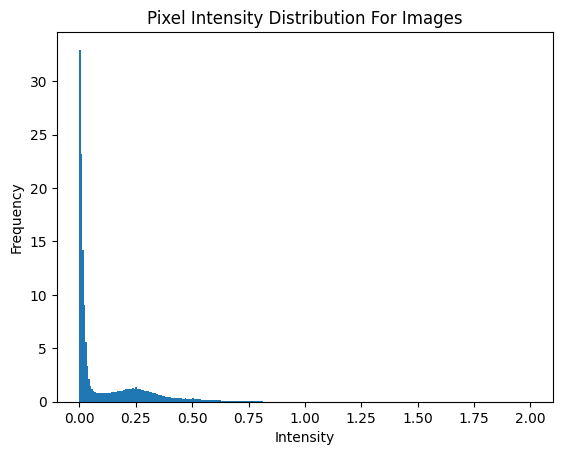

In [25]:
plt.hist(images.ravel(), bins=300, range=(0, 2), density=True)
plt.title("Pixel Intensity Distribution For Images")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()


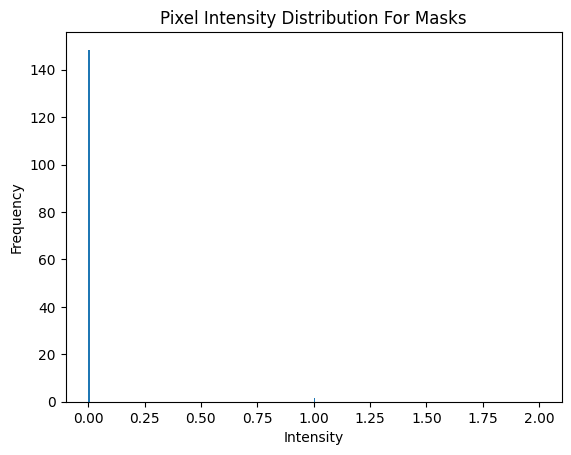

In [26]:
plt.hist(masks.ravel(), bins=300, range=(0, 2), density=True)
plt.title("Pixel Intensity Distribution For Masks")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

## Transform the image to grayscale

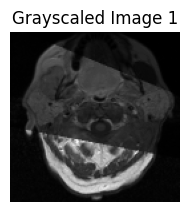

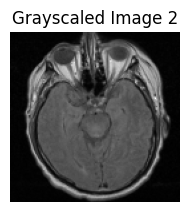

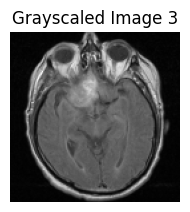

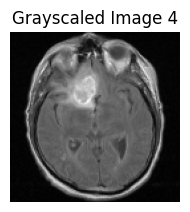

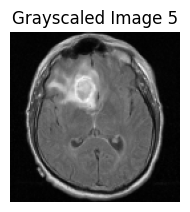

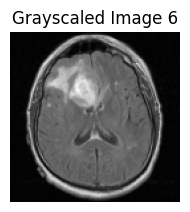

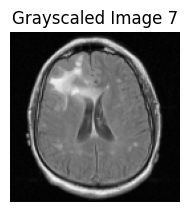

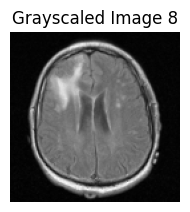

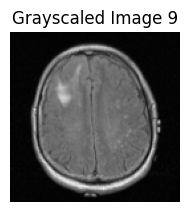

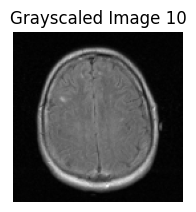

In [27]:
import matplotlib.pyplot as plt
gray_images = []
for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image    
    gray_images.append(gray)

for (i,img) in enumerate(gray_images[:10]):
    plt.figure(figsize=(2, 3))
    plt.imshow(img, cmap='gray')
    plt.title(f"Grayscaled Image {i+1}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Slice Images and masks

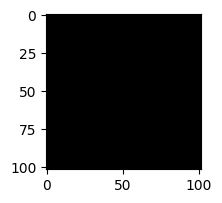

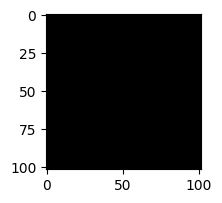

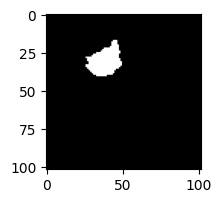

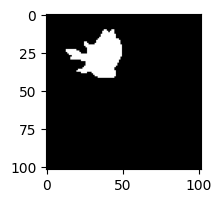

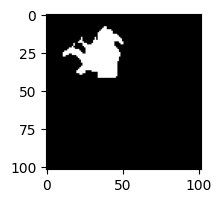

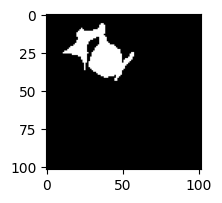

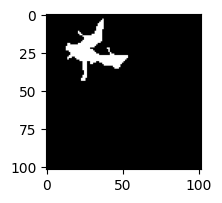

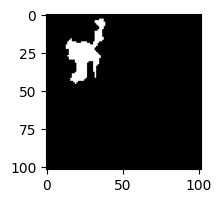

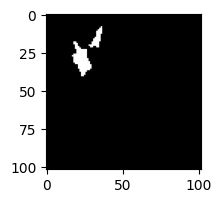

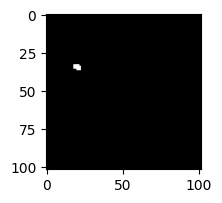

In [28]:
def auto_crop_image(image, mask):
    _, binary_image = cv2.threshold(gray, 0.18, 1, cv2.THRESH_BINARY)
    # Find nonzero pixels in the image
    coords = cv2.findNonZero(binary_image)

    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)  # Get bounding box around the non-black region
        cropped_image = image[y:y+h, x:x+w]  
        cropped_mask = mask[y:y+h, x:x+h]
        return cropped_image, cropped_mask
    else:
        return image, mask
cropped_images = []
cropped_masks = []
for (i,img) in enumerate(gray_images):
    cropped_img, cropped_mask = auto_crop_image(img, masks[i])
    cropped_images.append(cropped_img)
    cropped_masks.append(cropped_mask)

for img in cropped_masks[:10]:
    plt.figure(figsize=(2, 3))
    plt.imshow(img, cmap='gray')

## Final Resize

In [29]:
final_images = []
final_masks = []
IMAGE_DIMS = (IMAGE_SIZE,IMAGE_SIZE)
MASK_DIMS = (MASK_SIZE, MASK_SIZE)
for img in cropped_images:
    image_resized = cv2.resize(img, IMAGE_DIMS, interpolation=cv2.INTER_LINEAR)
    final_images.append(image_resized)
for img in cropped_masks:
    mask_resized = cv2.resize(img, MASK_DIMS, interpolation=cv2.INTER_LINEAR)
    final_masks.append(mask_resized)

del images
del masks

## Display of 10 images after preprocessing with their corresponding masks

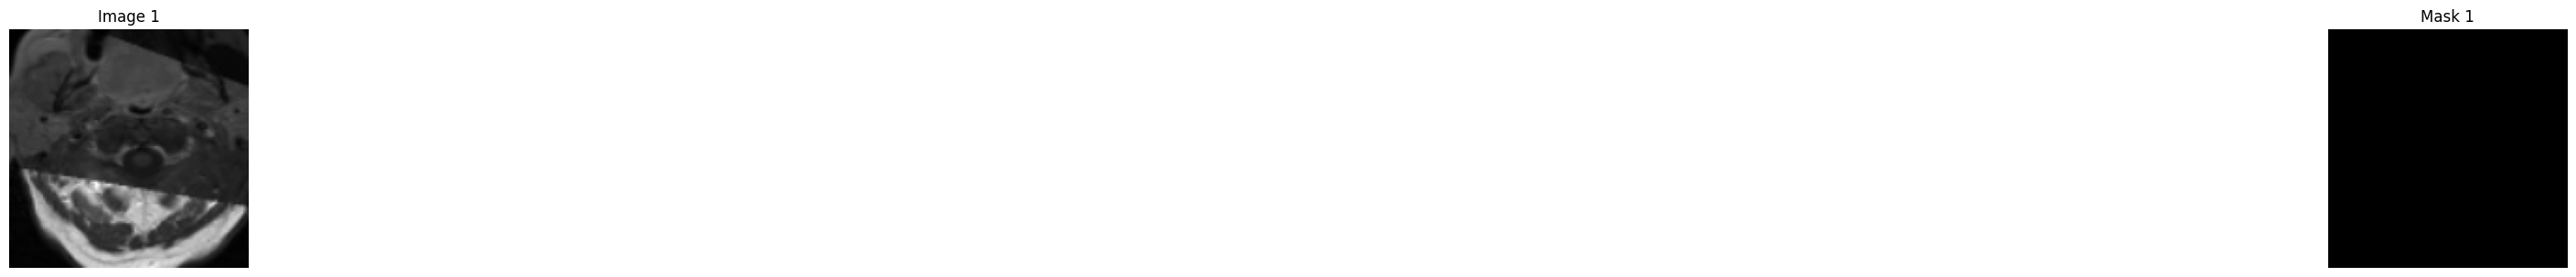

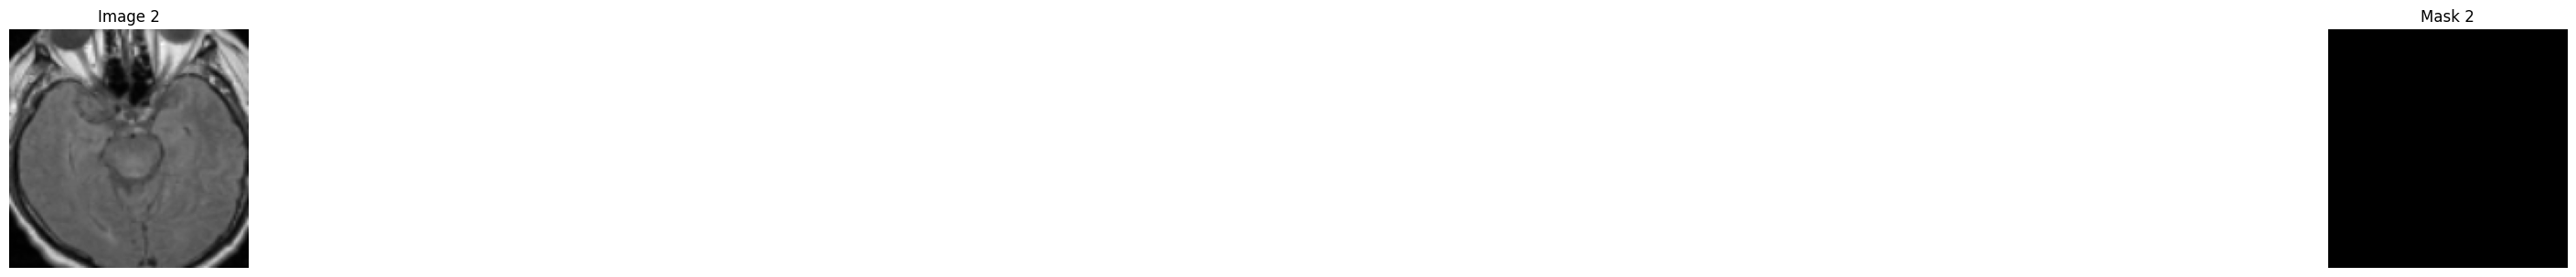

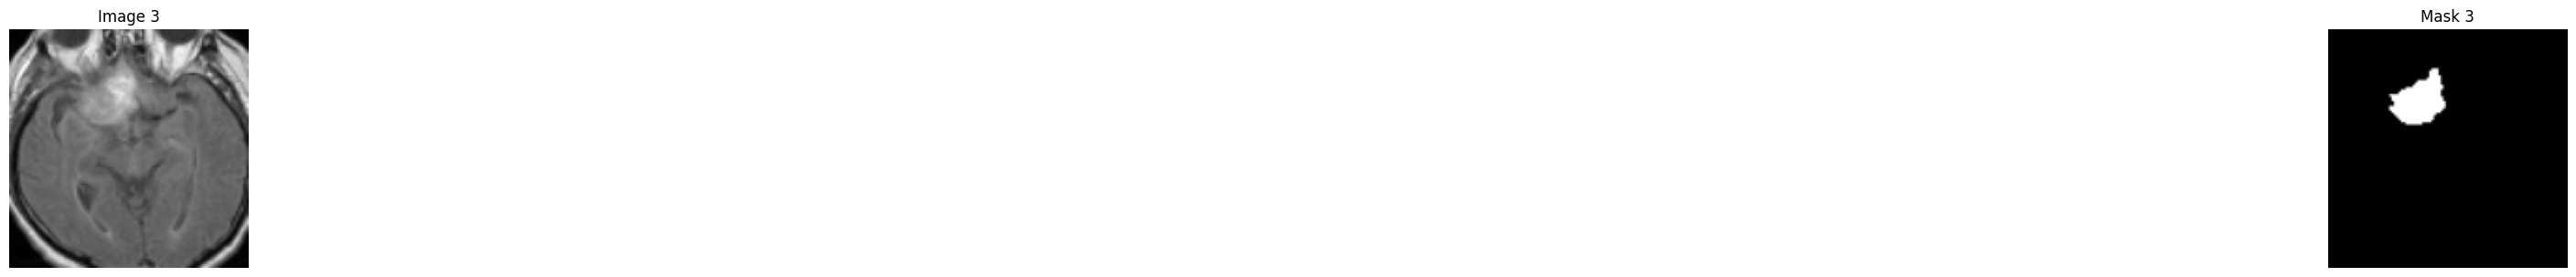

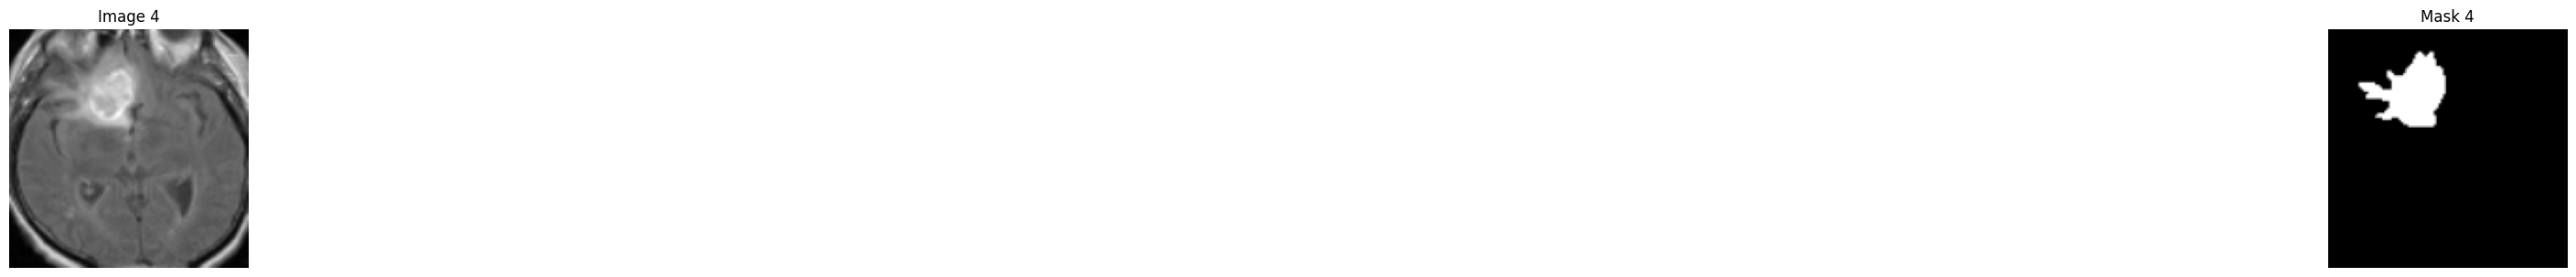

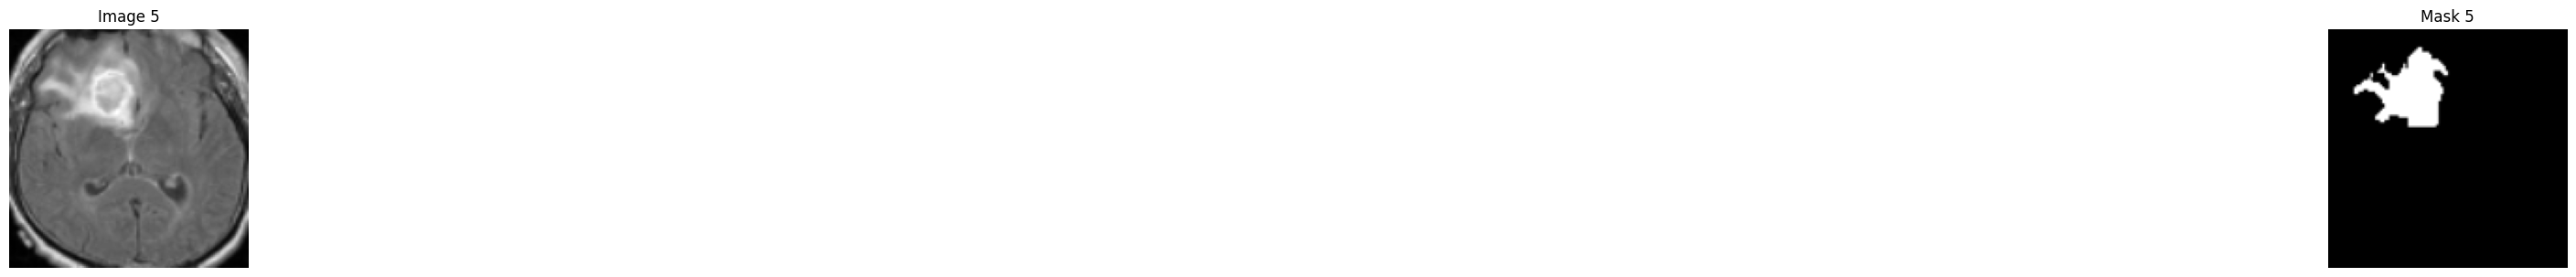

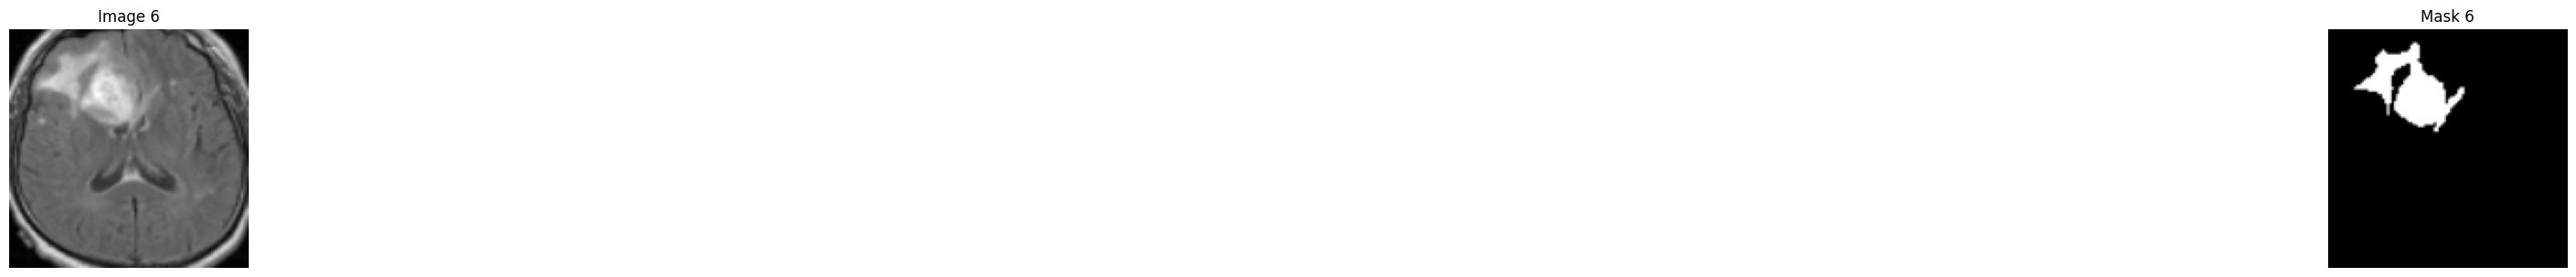

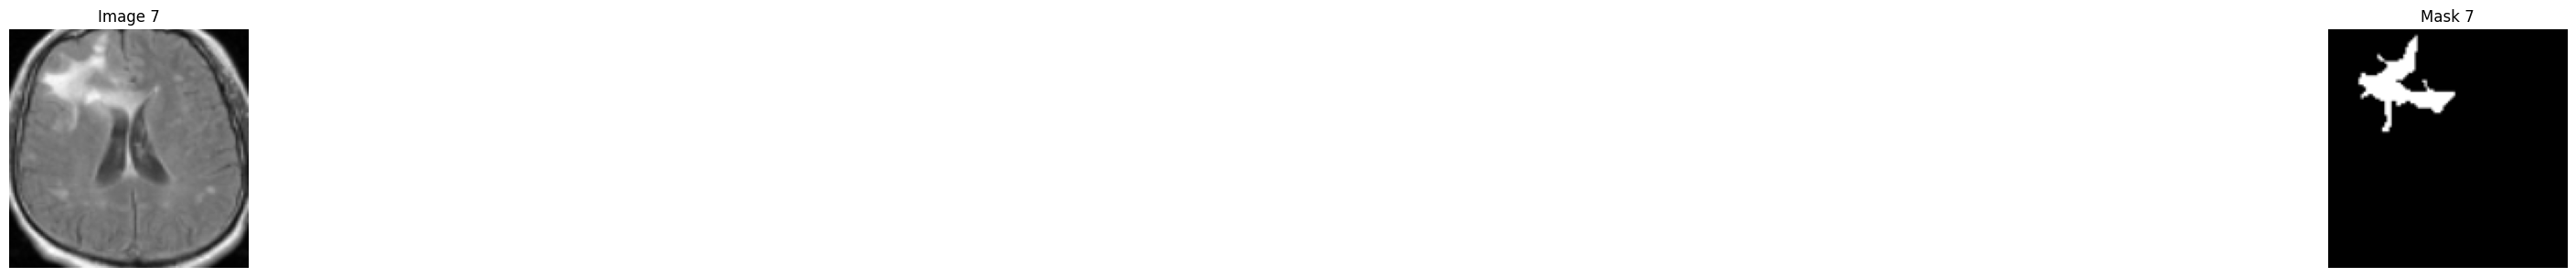

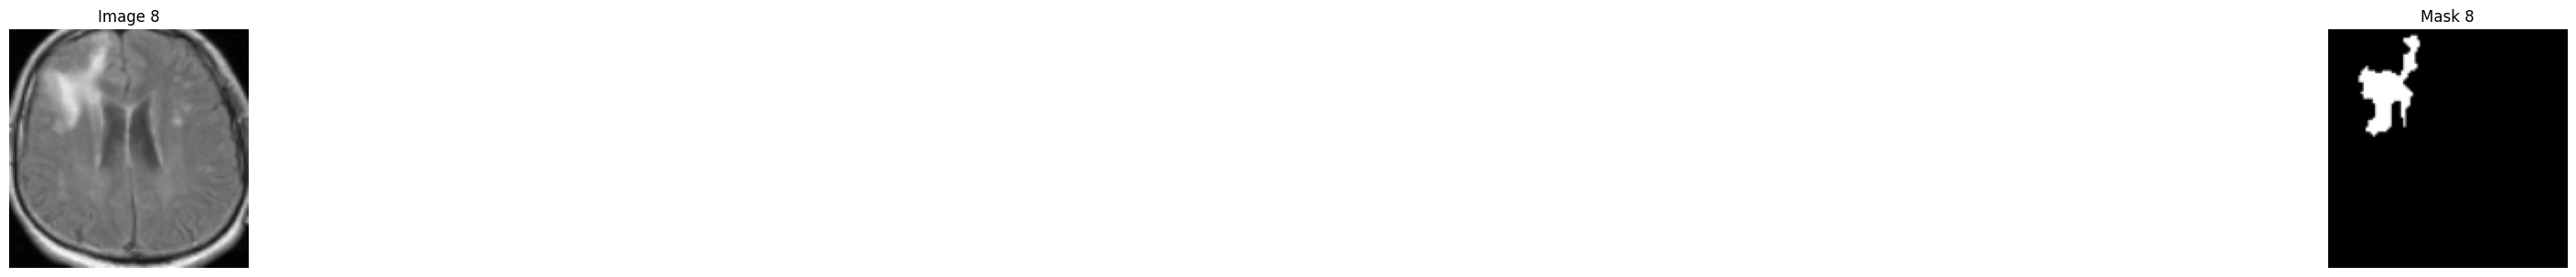

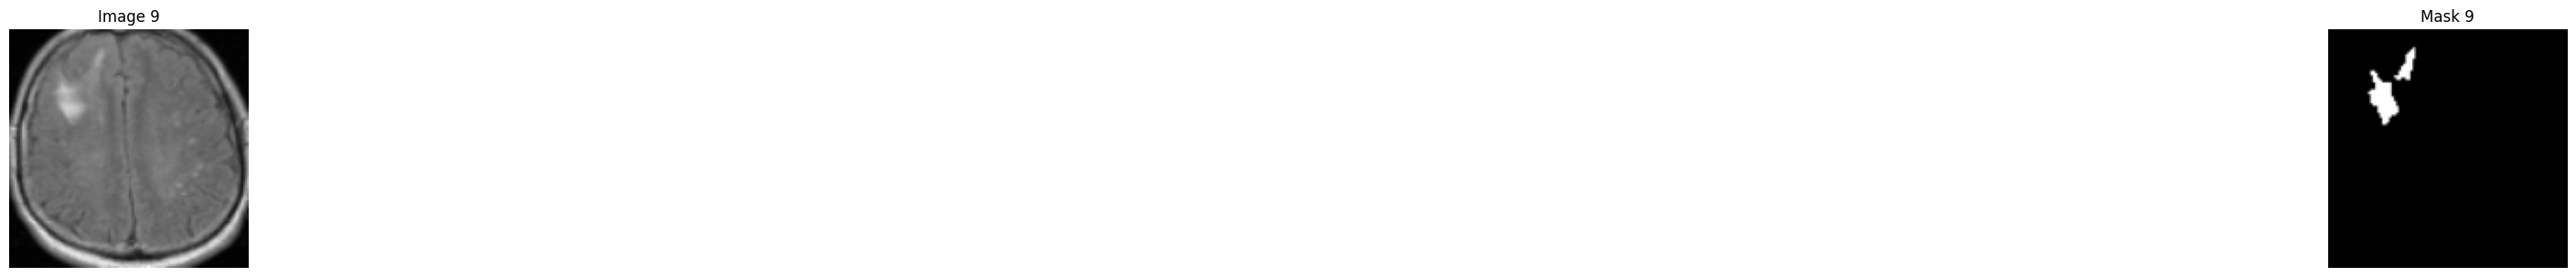

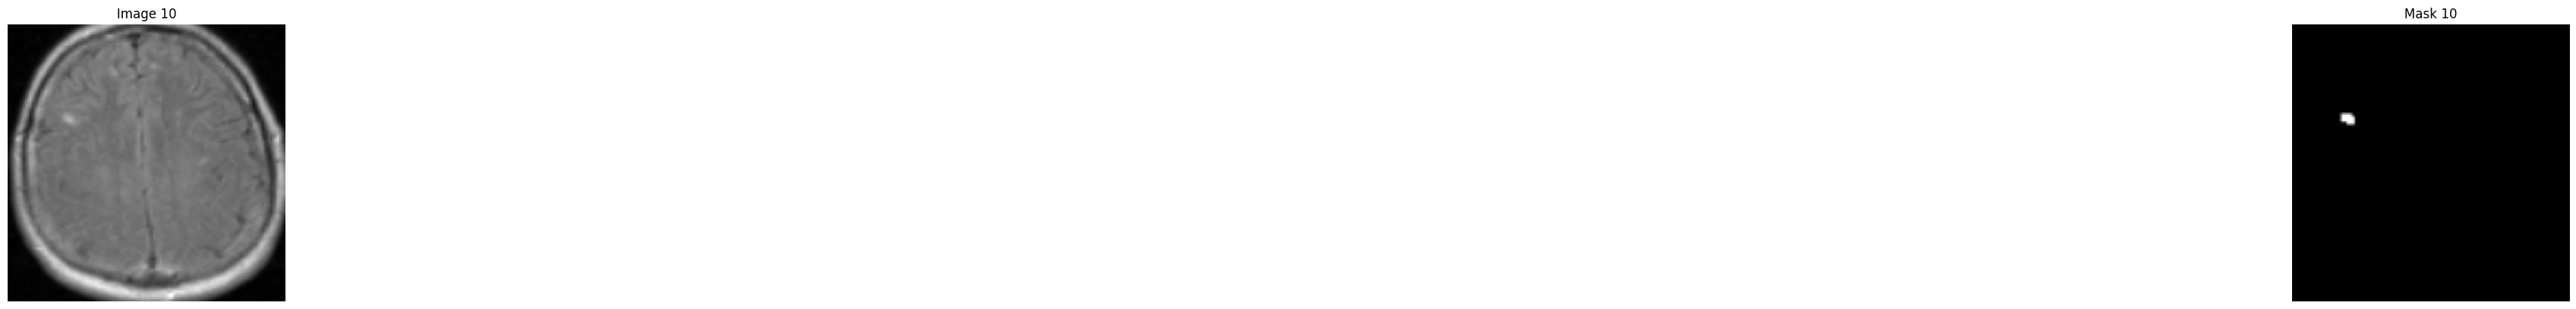

In [30]:
for i, image in enumerate(final_images[:10]):
    plt.figure(figsize=(60, 40))
    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')
    
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(final_masks[i], cmap='gray')
    plt.title(f"Mask {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Shaping and Train/Test Division

In [31]:
from sklearn.model_selection import train_test_split

X = np.expand_dims(final_images, axis=-1)
y = np.expand_dims(final_masks, axis=-1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Bonus: Implementation of ResUnet


## Trying to Decrease the Training Time 

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


# Shaping and Train/Test Division

In [37]:
from sklearn.model_selection import train_test_split
import numpy as np
IMAGE_SIZE = 128
MASK_SIZE = 128
X = np.expand_dims(final_images, axis=-1)
y = np.expand_dims(final_masks, axis=-1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, BatchNormalization, Add, Activation, concatenate
from tensorflow.keras.models import Model

def residual_block(x, filters, ker_init):
    shortcut = x

    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = BatchNormalization()(x)
    
    if int(shortcut.shape[-1]) != filters:
        shortcut = Conv2D(filters, 1, padding='same', kernel_initializer=ker_init)(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resunet(inputs, ker_init, dropout):
    conv1 = residual_block(inputs, 32, ker_init)
    conv1 = residual_block(conv1, 32, ker_init)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = residual_block(pool1, 64, ker_init)
    conv2 = residual_block(conv2, 64, ker_init)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = residual_block(pool2, 128, ker_init)
    conv3 = residual_block(conv3, 128, ker_init)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = residual_block(pool3, 256, ker_init)
    conv4 = residual_block(conv4, 256, ker_init)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = residual_block(pool4, 512, ker_init)
    conv5 = residual_block(conv5, 512, ker_init)
    drop5 = Dropout(dropout)(conv5)

    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(256, 2, padding='same', kernel_initializer=ker_init, activation='relu')(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = residual_block(merge6, 256, ker_init)
    conv6 = residual_block(conv6, 256, ker_init)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(128, 2, padding='same', kernel_initializer=ker_init, activation='relu')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = residual_block(merge7, 128, ker_init)
    conv7 = residual_block(conv7, 128, ker_init)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(64, 2, padding='same', kernel_initializer=ker_init, activation='relu')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = residual_block(merge8, 64, ker_init)
    conv8 = residual_block(conv8, 64, ker_init)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(32, 2, padding='same', kernel_initializer=ker_init, activation='relu')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = residual_block(merge9, 32, ker_init)
    conv9 = residual_block(conv9, 32, ker_init)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    return Model(inputs=inputs, outputs=conv10)

IMAGE_SIZE = 128
input_layer = Input((IMAGE_SIZE, IMAGE_SIZE, 1))
res_model = build_resunet(input_layer, 'he_normal', 0.2)


# Metrics

In [39]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = tf.cast(K.flatten(y_true[:,:,:,0]), tf.float32)
    y_pred_f = tf.cast(K.flatten(y_pred[:,:,:,0]), tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth))
    return iou

def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


# Compile and Train

In [41]:
import keras


res_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', iou_coef, dice_coef, precision, sensitivity, specificity]
)

res_model.summary()

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=3,         
        min_lr=1e-5,       
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True
    )
]

history = res_model.fit(
    X_train, y_train,
    epochs=80,             
    batch_size=10,
    callbacks=callbacks,
    validation_data=(X_val, y_val)
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_3 (Cast)             │ (None, 128, 128, 1)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 128, 128, 32)   │            320 │ cast_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 128, 128, 32)   │            128 │ conv2d_73[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, 128, 128, 32)   │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_4 (Cast)             │ (None, 128, 128, 1)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ activation_36[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 128, 128, 32)   │             64 │ cast_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_46    │ (None, 128, 128, 32)   │            128 │ conv2d_74[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_47    │ (None, 128, 128, 32)   │            128 │ conv2d_75[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 128, 128, 32)   │              0 │ batch_normalization_4… │
│                           │                        │                │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_37             │ (None, 128, 128, 32)   │              0 │ add_18[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ activation_37[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 128, 128, 32)   │            128 │ conv2d_76[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_38             │ (None, 128, 128, 32)   │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 15,993,601 (61.01 MB)

 Trainable params: 15,978,881 (60.95 MB)

 Non-trainable params: 14,720 (57.50 KB)

Epoch 1/80
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9936 - dice_coef: 0.7975 - iou_coef: 0.8837 - loss: 0.0091 - precision: 0.8455 - sensitivity: 0.8288 - specificity: 0.9979
Epoch 1: val_loss improved from inf to 0.02025, saving model to model_.01-0.020246.weights.h5
315/315 ━━━━━━━━━━━━━━━━━━━━ 99s 150ms/step - accuracy: 0.9936 - dice_coef: 0.7974 - iou_coef: 0.8837 - loss: 0.0091 - precision: 0.8455 - sensitivity: 0.8288 - specificity: 0.9979 - val_accuracy: 0.9915 - val_dice_coef: 0.7036 - val_iou_coef: 0.8358 - val_loss: 0.0202 - val_precision: 0.7329 - val_sensitivity: 0.6939 - val_specificity: 0.9973 - learning_rate: 0.0010
Epoch 2/80
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9933 - dice_coef: 0.7858 - iou_coef: 0.8808 - loss: 0.0099 - precision: 0.8244 - sensitivity: 0.8264 - specificity: 0.9976
Epoch 2: val_loss improved from 0.02025 to 0.01661, saving model to model_.02-0.016611.weights.h5
315/315 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.

# Plot Results

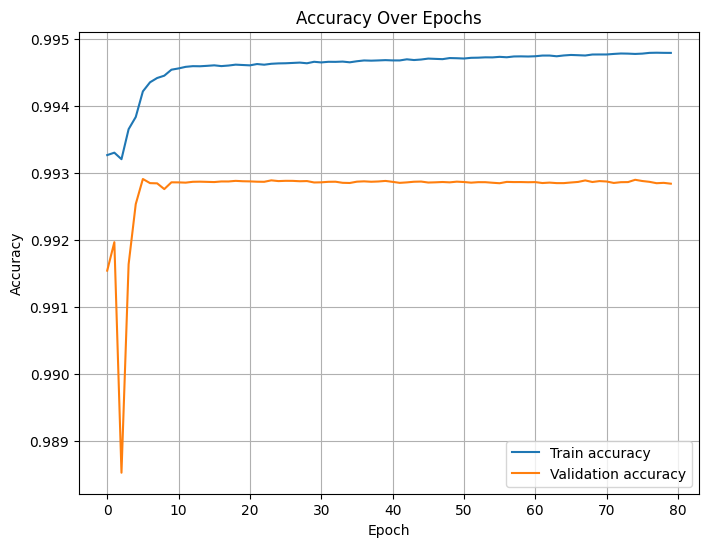

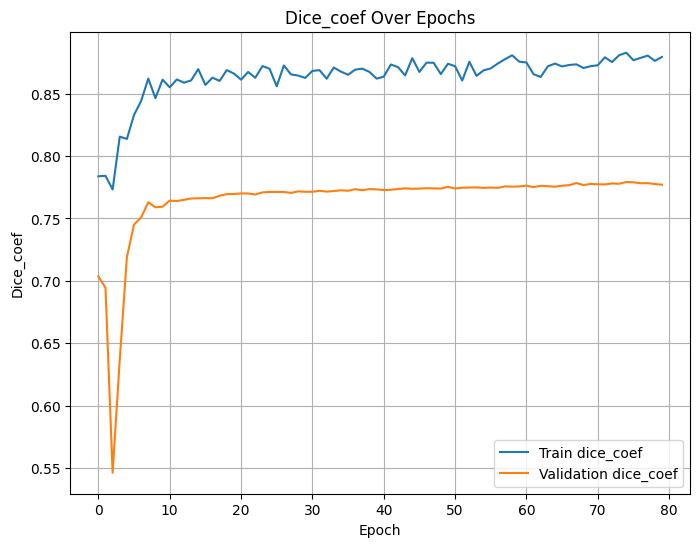

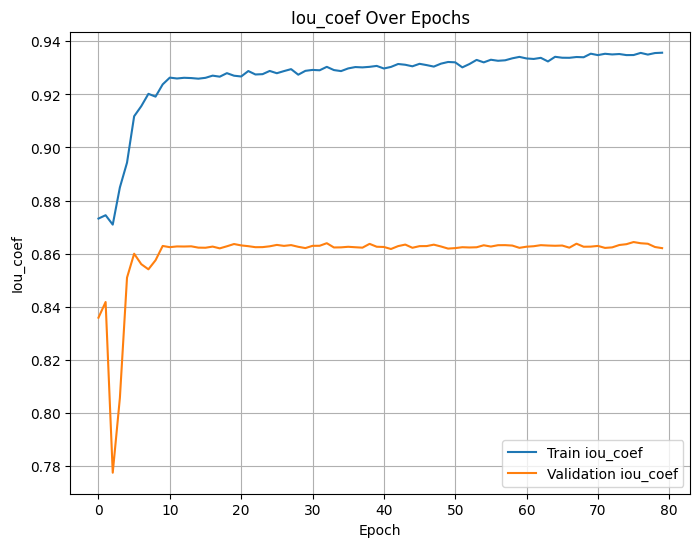

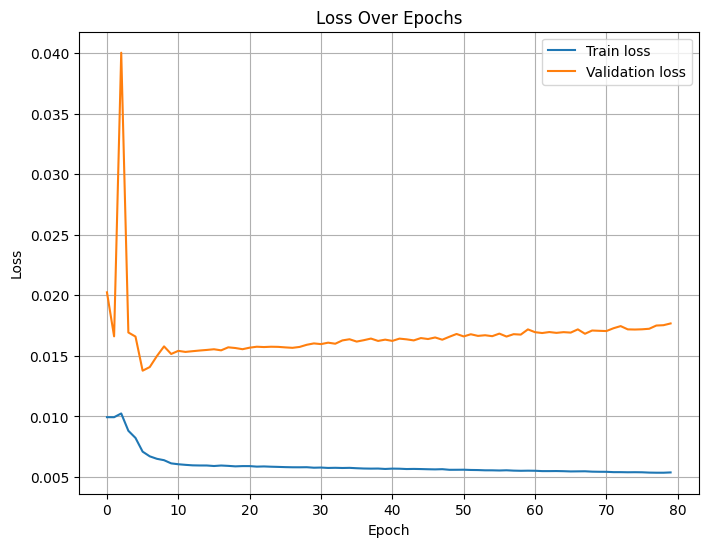

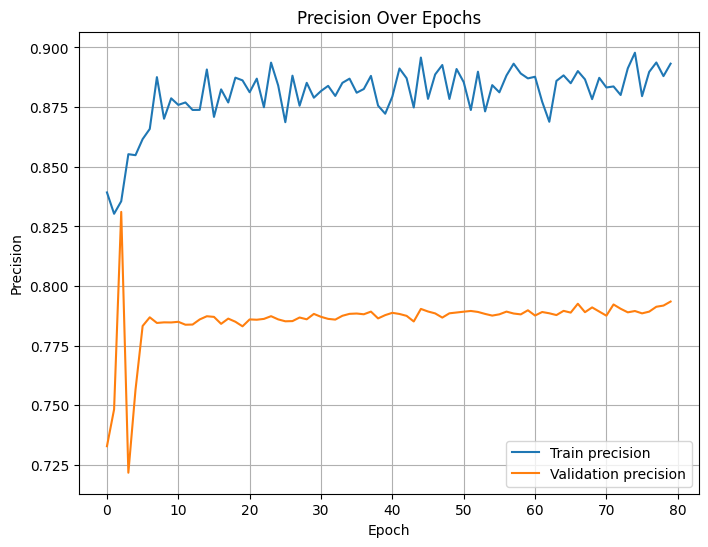

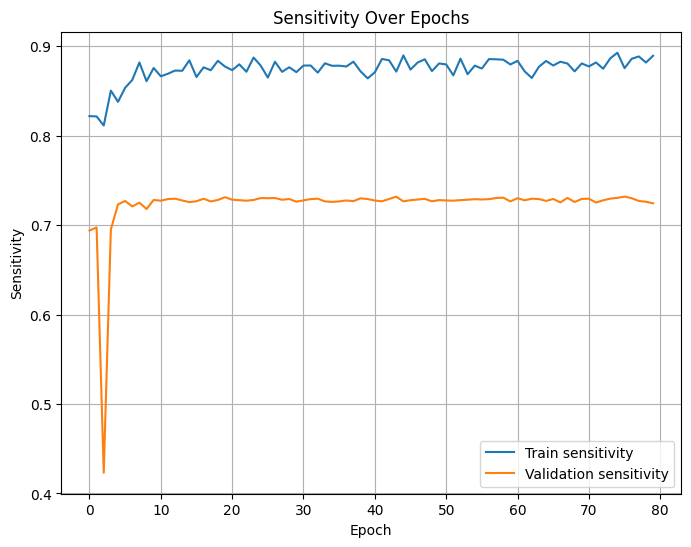

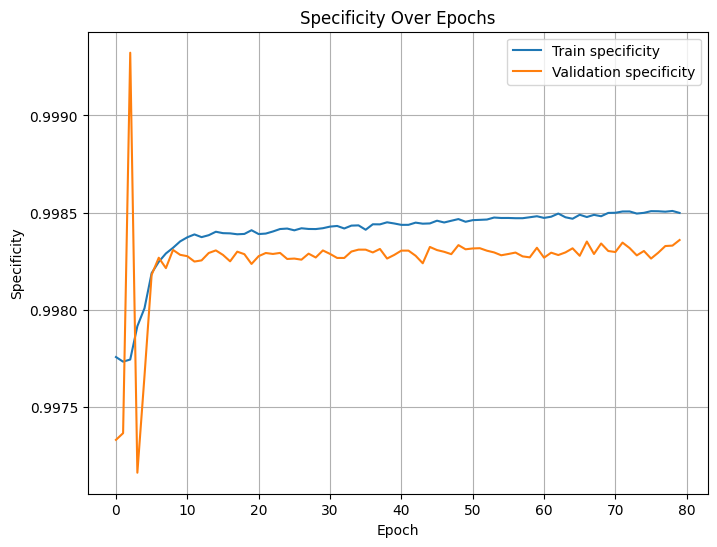

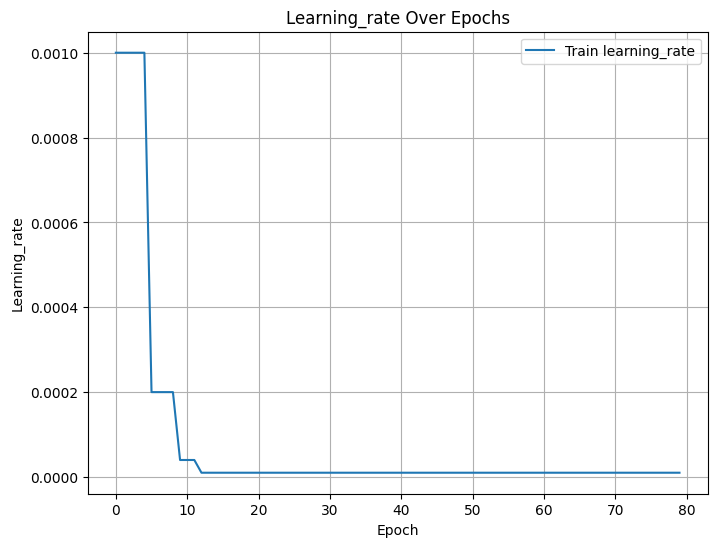

In [42]:
for metric in history.history.keys():
    if metric.startswith("val_"):
        metric = metric[4:]
        if metric in history.history:
            continue

    plt.figure(figsize=(8, 6))
    if metric in history.history:
        plt.plot(history.history[metric], label=f"Train {metric}")
    
    val_metric = f"val_{metric}"
    if val_metric in history.history:
        plt.plot(history.history[val_metric], label=f"Validation {metric}")
    
    plt.title(f"{str(metric).capitalize()} Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(str(metric).capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()


# Test Samples

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 627ms/step


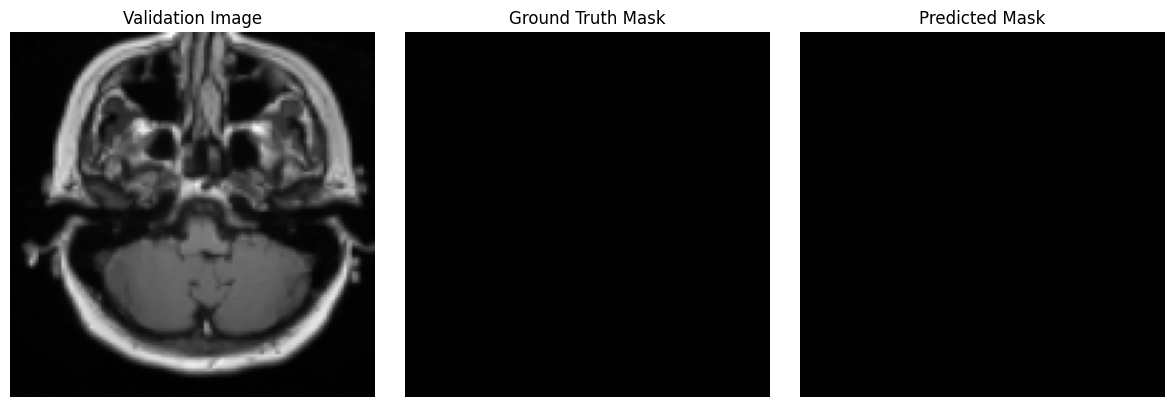

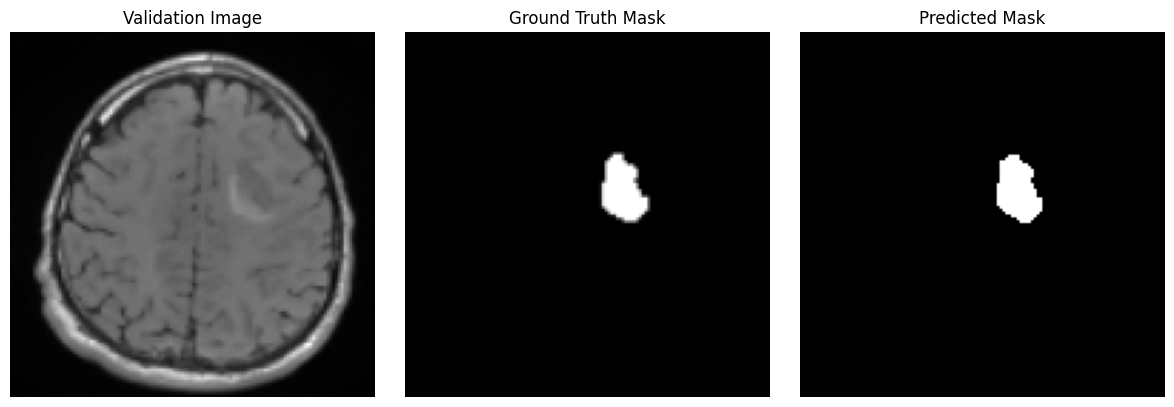

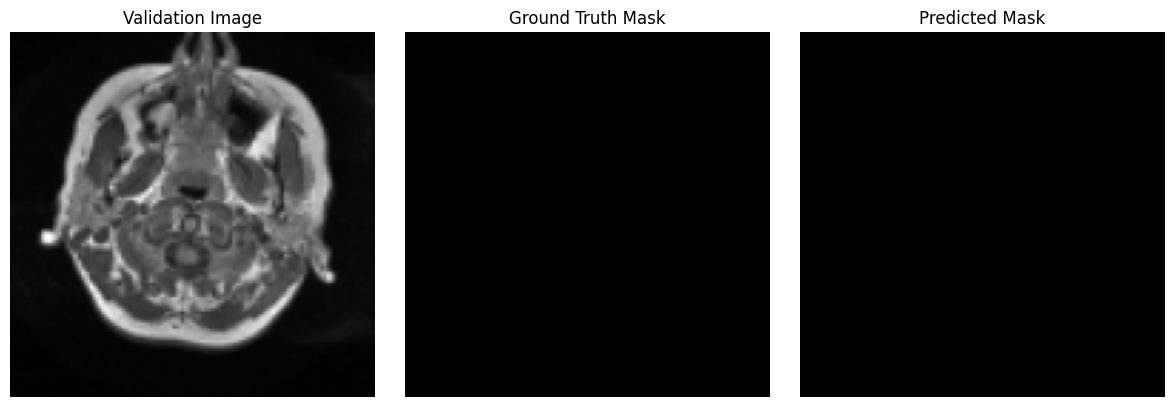

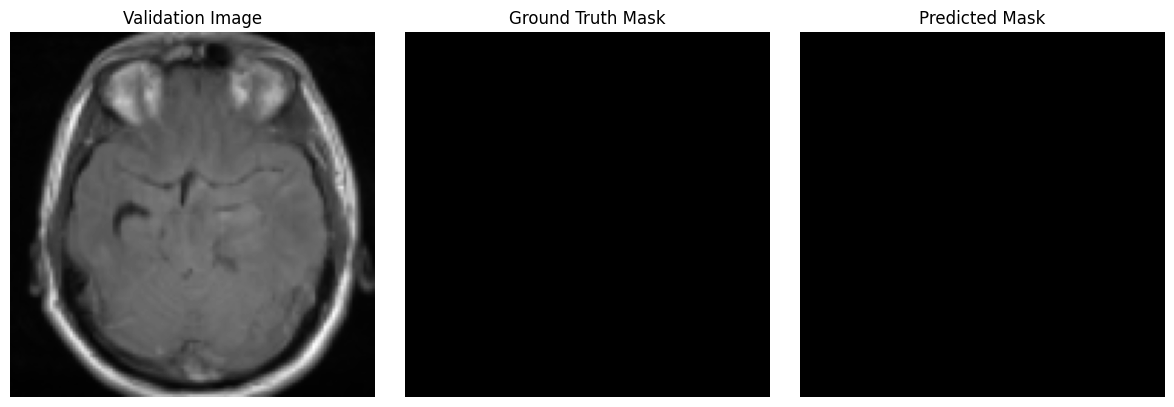

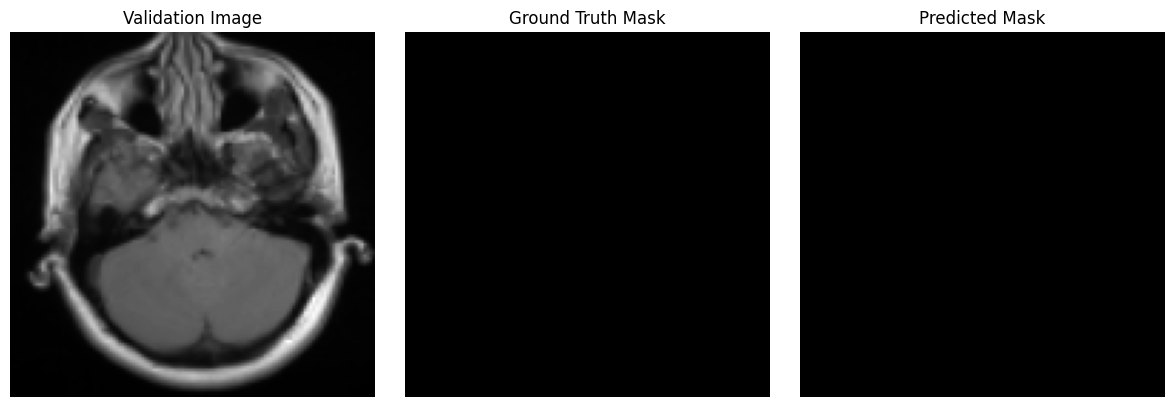

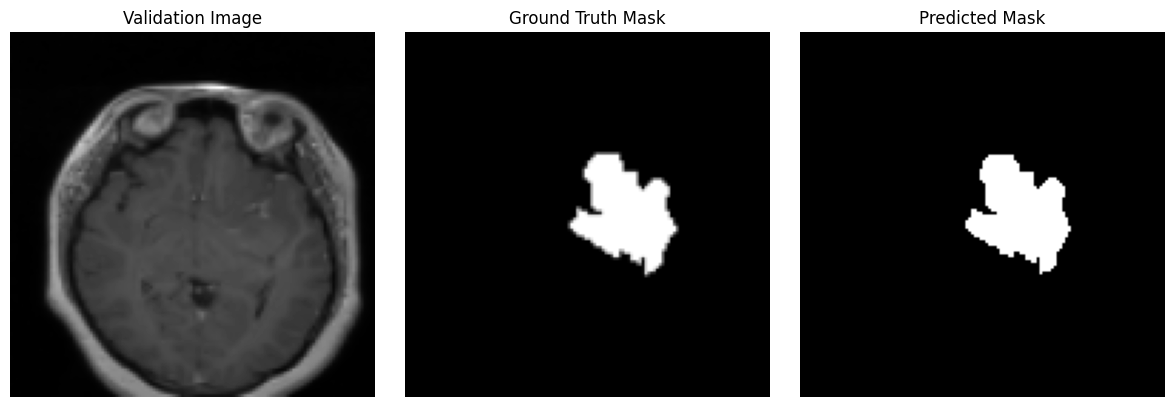

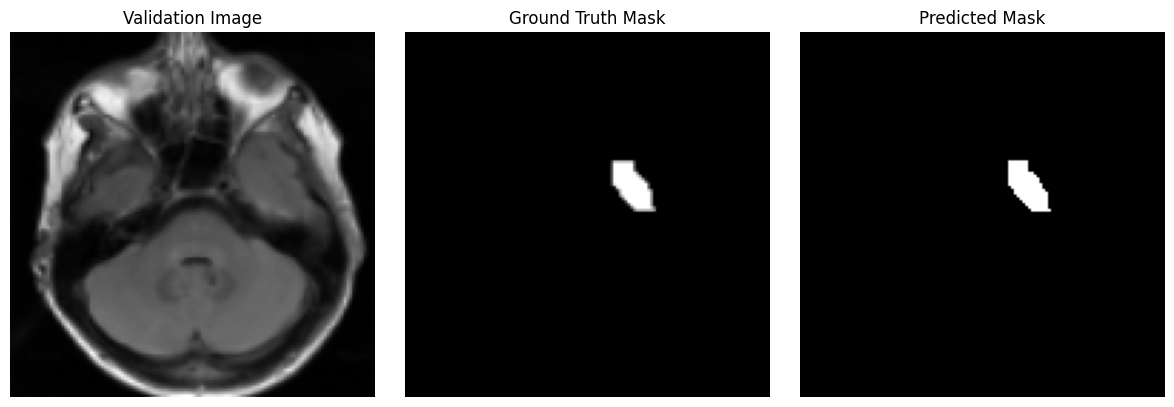

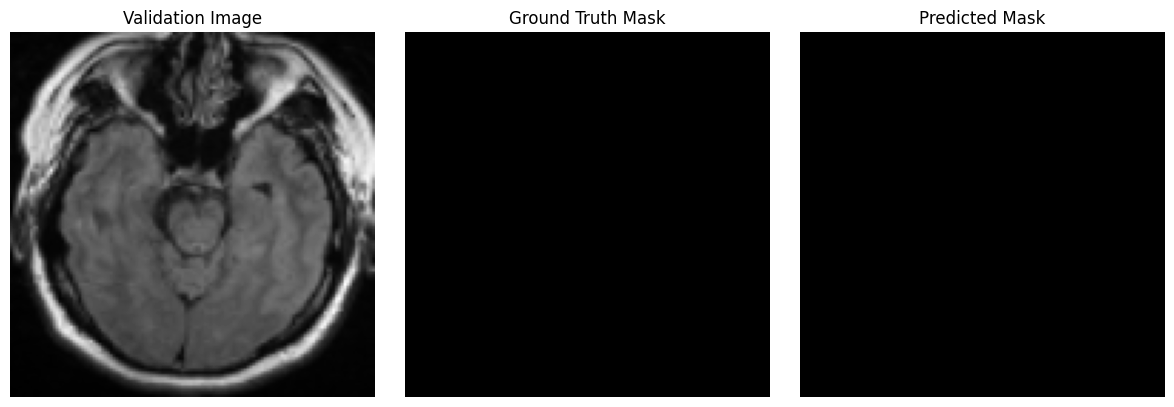

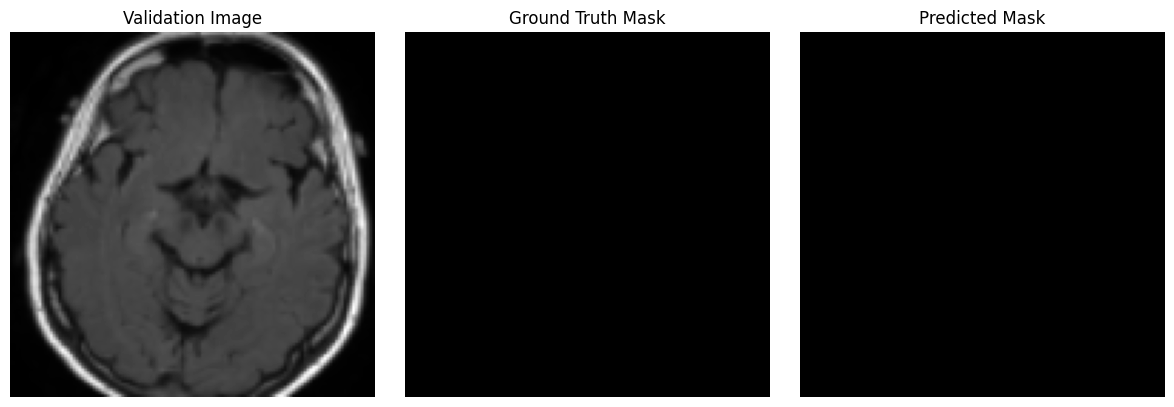

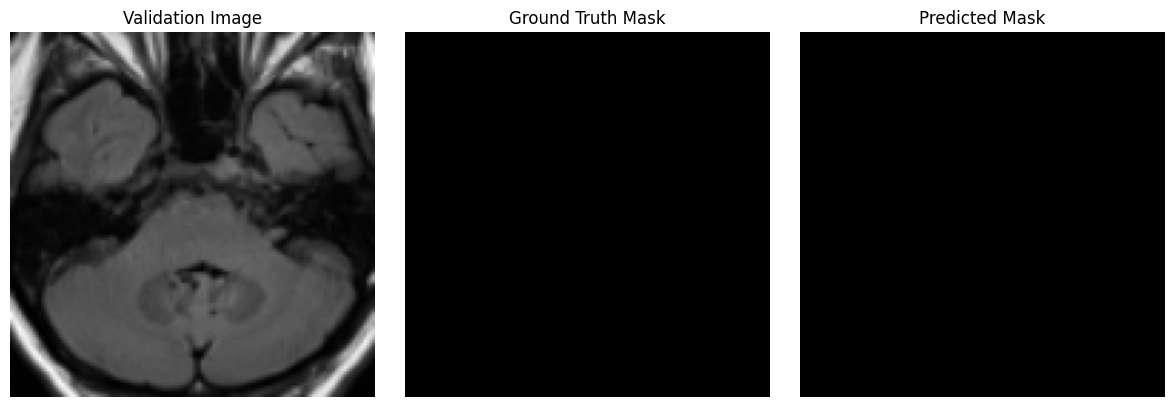

In [44]:
y_pred = res_model.predict(X_test)
y_pred_bin = (y_test > 0.5).astype(np.uint8)

n_samples = 10

sample_indices = np.random.choice(range(len(X_test)), size=n_samples, replace=False)

for idx in sample_indices:
    image = X_test[idx, :, :, 0]
    true_mask = y_test[idx, :, :, 0]
    pred_mask = y_pred_bin[idx, :, :, 0]
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Validation Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Test Metrics

In [46]:
import tensorflow as tf

paper_names = ['loss', 'accuracy', 'iou_coef', 'precision', 'sensitivity', 'specificity', 'dice_coef']
paper_results = map(float, "0.0054 0.9981 0.9130 0.9974 0.9971 0.9991 0.8409".split())
paper_dict = {k: v for k, v in zip(paper_names, paper_results)}

results = res_model.evaluate(X_test, y_test, batch_size=8, verbose=1, return_dict=True)

print("==== Test Metrics ====")
print("\t\tMine\tPaper")
for k, v in results.items():
    print(f" - {k}:\t{v:.4f}\t{paper_dict[k]:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.9933 - dice_coef: 0.7699 - iou_coef: 0.8510 - loss: 0.0160 - precision: 0.8273 - sensitivity: 0.7371 - specificity: 0.9984
==== Test Metrics ====
		Mine	Paper
 - accuracy:	0.9940	0.9981
 - dice_coef:	0.7891	0.8409
 - iou_coef:	0.8543	0.9130
 - loss:	0.0131	0.0054
 - precision:	0.8237	0.9974
 - sensitivity:	0.7695	0.9971
 - specificity:	0.9984	0.9991
